In [1]:
# Change Directory to be outside the experiments folder
%cd ..

/home/vvrbeast/Desktop/Giannis/Code/SPVD


# Load Data 

In [2]:
from datasets.shapenet_pointflow_sparse import ShapeNet15kPointCloudsSparseNoisy
from functools import partial
from torch.utils.data import DataLoader
import torchsparse
from torchsparse.utils.collate import sparse_collate_fn
from pclab.utils import DataLoaders
import torch
import torch.nn as nn

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
path = "/home/vvrbeast/Desktop/Giannis/Data/ShapeNetCore.v2.PC15k"

tr_dataset = ShapeNet15kPointCloudsSparseNoisy(
            categories= ['chair'], split='train',
            tr_sample_size=2048,
            te_sample_size=2048,
            scale=1.,
            root_dir=path,
            normalize_per_shape=False,
            normalize_std_per_axis=False, 
            random_subsample=True)

te_dataset = ShapeNet15kPointCloudsSparseNoisy(
            categories= ['chair'], split='val',
            tr_sample_size=2048,
            te_sample_size=2048,
            scale=1.,
            root_dir=path,
            normalize_per_shape=False,
            normalize_std_per_axis=False,
            random_subsample=True)

tr_dataset.set_voxel_size(1e-5)
tr_dataset.set_noise_params(beta_max=0.02)

te_dataset.set_voxel_size(1e-5)
te_dataset.set_noise_params(beta_max=0.02)

train_dl, valid_dl = map(partial(DataLoader, batch_size=32, shuffle=True, num_workers=8, drop_last=True, collate_fn=sparse_collate_fn), (tr_dataset, te_dataset))
dls = DataLoaders(train_dl, valid_dl)

(1, 1, 1)
Total number of data:4612
Min number of points: (train)2048 (test)2048
(1, 1, 1)
Total number of data:662
Min number of points: (train)2048 (test)2048


In [4]:
from pclab.learner import *
from pclab.utils import def_device
import fastcore.all as fc
from typing import Mapping
from copy import copy
from torcheval.metrics import Mean
from utils.callbacks import GradientClipCB
from utils.callbacks import CheckpointCB
from models.sparse_utils import PointTensor

class DDPMCB(Callback):
    
    def before_batch(self, learn): 
        pts = learn.batch['input']
        t = torch.tensor(learn.batch['t'])
        noise = learn.batch['noise']
        inp = (pts, t)
        learn.batch = (inp, noise.F)

def to_device(x, device=def_device):
    if isinstance(x, (torch.Tensor, torchsparse.SparseTensor)): return x.to(device)
    if isinstance(x, Mapping): return {k:v.to(device) for k,v in x.items()}
    return type(x)(to_device(o, device) for o in x)

class DeviceCBSparse(Callback):
    order = DDPMCB.order + 1
    def __init__(self, device=def_device): fc.store_attr()
    def before_fit(self, learn):
        if hasattr(learn.model, 'to'): learn.model.to(self.device)
    def before_batch(self, learn): learn.batch = to_device(learn.batch, device=self.device)


class LossCB(Callback):
    def __init__(self, *ms, **metrics):
        for o in ms: metrics[type(o).__name__] = o
        self.metrics = metrics
        self.all_metrics = copy(metrics)
        self.all_metrics['loss'] = self.loss = Mean()

    def _log(self, d): print(d)
    def before_fit(self, learn): learn.metrics = self
    def before_epoch(self, learn): [o.reset() for o in self.all_metrics.values()]

    def after_epoch(self, learn):
        log = {k:f'{v.compute():.3f}' for k,v in self.all_metrics.items()}
        log['epoch'] = learn.epoch
        log['train'] = 'train' if learn.model.training else 'eval'
        self._log(log)

    def after_batch(self, learn):
        x,y,*_ = learn.batch
        #for m in self.metrics.values(): m.update(to_cpu(learn.preds), y)
        self.loss.update(to_cpu(learn.loss), weight=2)

# Load the model

In [5]:
from models.ddpm_unet_attn import SPVUnet
get_model = partial(SPVUnet, voxel_size=0.1, nfs = (64, 128, 128, 256), pres=1e-5, attn_chans=16, attn_start=3)

## LRFIND

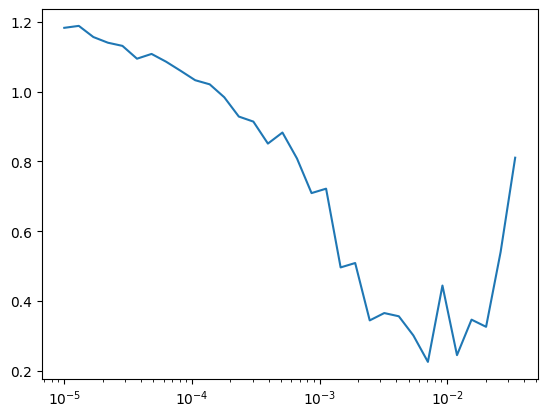

In [6]:
ddpm_cb = DDPMCB()
model = get_model()
learn = TrainLearner(model, dls, nn.MSELoss(), cbs=[ddpm_cb, DeviceCBSparse(), GradientClipCB()], opt_func=torch.optim.Adam)
learn.lr_find(max_mult=3)

In [ ]:
lr = 0.0002 
epochs = 5000 

model = get_model()

# scheduler
total_steps = epochs * len(dls.train)
#sched = partial(torch.optim.lr_scheduler.OneCycleLR, max_lr=lr, total_steps = total_steps)

# Callbacks
ddpm_cb = DDPMCB()
checkpoint_cb = CheckpointCB(100, 'ddpm_unet_attn_64_128_256_256', run_params={})
cbs = [ddpm_cb, DeviceCBSparse(), ProgressCB(plot=False), LossCB(), GradientClipCB(), checkpoint_cb] #BatchSchedCB(sched),

learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(epochs)

loss,epoch,train
0.357,0,train
0.260,0,eval
0.251,1,train
0.223,1,eval


## Inference

In [ ]:
from utils.schedulers import DDPMSparseSchedulerGPU
from utils.visualization import quick_vis_batch
vis_batch = partial(quick_vis_batch, x_offset = 8, y_offset=8)

In [ ]:
ddpm_sched = DDPMSparseSchedulerGPU(n_steps=1000, beta_min=0.0001, beta_max=0.02, pres=1e-5)
preds = ddpm_sched.sample(model, 32, 2048)
vis_batch(preds)